In [1]:
import utils
import loader
import graphics
import pandas as pd
import numpy as np

# Usar las trazas de Simva o las de Scorm
use_scorm = False

files_path = "./trazas/simva/"
cols_to_drop = ["stored", "id", "version", "actor.account.homePage", "authority.name", "authority.homePage", "context.contextActivities.category", "context.registration", "object.definition.name.en-US", "object.definition.description.en-US", "object.definition.type", "verb.display.en-US", "verb.id", "object.objectType", "result.response", "result.score.scaled", "result.completion", "result.success"]

if use_scorm:
	files_path = "./trazas/scorm/"
	cols_to_drop = ["verb.display.en-US", "id", "stored", "version", "actor.objectType", "actor.account.homePage", "result.success", "result.completion", "context.registration", "authority.objectType", "authority.account.homePage", "authority.account.name", "authority.name", "object.definition.description.en-US", "object.definition.name.en-US", "object.objectType", "context.contextActivities.category"]

files_extension = "json"

############################
# Datos comunes
# Sacado de los JSONs
############################
all_df, users_individual_df_list = loader.load_all_files(files_path, files_extension, "timestamp", cols_to_drop, use_scorm)
n_users = len(users_individual_df_list)

game_starts_conditions = [("object.id", "GameStart")]
game_starts = utils.find_indices_by_conditions(all_df, game_starts_conditions)
game_starts = all_df.iloc[game_starts]
game_starts = game_starts.drop_duplicates(subset=["actor.account.name"])

gender_sexuality_combinations = [
	("male", "heterosexual"), 
	("male", "homosexual"), 
	("male", "bisexual"), 
	("female", "heterosexual"), 
	("female", "homosexual"), 
	("female", "bisexual")
]
demography = game_starts[["actor.account.name", "Gender", "Sexuality"]].values.tolist()

demography_info = {}
for user in demography:
	demography_info.update({user[0]: (user[1], user[2])})



In [2]:
import pandas as pd
import loader

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

cols_to_drop = ["ID de respuesta", "Fecha de envío",  "Última página", "Lenguaje inicial", "Semilla", "Fecha de inicio", "Fecha de la última acción"]

surveys_path = "./encuestas/pre/"
pre = loader.load_surveys(surveys_path, files_extension, cols_to_drop)
display(pre)

surveys_path = "./encuestas/post/"
post = loader.load_surveys(surveys_path, files_extension, cols_to_drop)
display(post)


,Código de acceso,Edad,Género,Género [Otro],¿Cómo de peligrosas consideras las siguientes acciones? [Tener tu perfil en público],¿Cómo de peligrosas consideras las siguientes acciones? [Agregar a contactos o aceptar como seguidores a personas que no conoces en la vida real],¿Cómo de peligrosas consideras las siguientes acciones? [Unirte a grupos o comunidades o servidores públicos],¿Cómo de peligrosas consideras las siguientes acciones? [Hablar por chat (escrito o de voz) con alguien que no conoces en la vida real],¿Cómo de peligrosas consideras las siguientes acciones? [Hablar por videollamada con alguien que no conoces en la vida real],¿Cómo de peligrosas consideras las siguientes acciones? [Entablar amistad con alguien que no conoces en la vida real],¿Cómo de peligrosas consideras las siguientes acciones? [Quedar en la vida real con una persona que has conocido en internet],¿Cómo de peligrosas consideras las siguientes acciones? [Hablar con adultos por internet],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio fotos de tu cara en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio fotos de tus amigos en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio fotos de ti en bañador en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio tu sexualidad en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio tu número de teléfono en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio tu nombre completo en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio tu cumpleaños o edad o fecha de nacimiento en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio tu centro de estudios en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio el país en el que vives en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio la provincia en la que vives en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio la calle en la que vives en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio la dirección de tu casa en un perfil público de una red social]
0,6818e721fbe4c00023c50add_slpa,13,Masculino,,4 - Algo peligroso,5 - Peligroso,3 - Algo seguro,5 - Peligroso,4 - Algo peligroso,4 - Algo peligroso,4 - Algo peligroso,5 - Peligroso,5 - Peligroso,4 - Algo peligroso,4 - Algo peligroso,4 - Algo peligroso,2 - Seguro,4 - Algo peligroso,3 - Algo seguro,3 - Algo seguro,4 - Algo peligroso,3 - Algo seguro,4 - Algo peligroso,5 - Peligroso
1,6818e721fbe4c00023c50add_weoh,14,Femenino,,2 - Seguro,3 - Algo seguro,4 - Algo peligroso,4 - Algo peligroso,3 - Algo seguro,2 - Seguro,3 - Algo seguro,4 - Algo peligroso,4 - Algo peligroso,5 - Peligroso,4 - Algo peligroso,3 - Algo seguro,4 - Algo peligroso,5 - Peligroso,4 - Algo peligroso,2 - Seguro,5 - Peligroso,4 - Algo peligroso,5 - Peligroso,5 - Peligroso
2,6818e721fbe4c00023c50add_jsut,17,Otro,No binario,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo seguro,3 - Algo s

,Código de acceso,¿Cómo de peligrosas consideras las siguientes acciones? [Tener tu perfil en público],¿Cómo de peligrosas consideras las siguientes acciones? [Agregar a contactos o aceptar como seguidores a personas que no conoces en la vida real],¿Cómo de peligrosas consideras las siguientes acciones? [Unirte a grupos o comunidades o servidores públicos],¿Cómo de peligrosas consideras las siguientes acciones? [Hablar por chat (escrito o de voz) con alguien que no conoces en la vida real],¿Cómo de peligrosas consideras las siguientes acciones? [Hablar por videollamada con alguien que no conoces en la vida real],¿Cómo de peligrosas consideras las siguientes acciones? [Entablar amistad con alguien que no conoces en la vida real],¿Cómo de peligrosas consideras las siguientes acciones? [Quedar en la vida real con una persona que has conocido en internet],¿Cómo de peligrosas consideras las siguientes acciones? [Hablar con adultos por internet],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio fotos de tu cara en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio fotos de tus amigos en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio fotos de ti en bañador en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio tu sexualidad en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio tu número de teléfono en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio tu nombre completo en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio tu cumpleaños o edad o fecha de nacimiento en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio tu centro de estudios en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio el país en el que vives en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio la provincia en la que vives en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio la calle en la que vives en un perfil público de una red social],¿Cómo de peligrosas consideras las siguientes acciones? [Publicar o tener visible en algún sitio la dirección de tu casa en un perfil público de una red social],¿Cuántas horas pasas al día en redes sociales?,¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [TikTok],¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [Instagram],¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [YouTube],¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [WhatsApp],¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [Facebook],¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [Twitter o X],¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [Discord],¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [Telegram],¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [Snapchat],¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [BeReal],¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [Reddit],¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [Tumblr],¿Con qué frecuencia usas las siguientes redes sociales o plataformas? [Pinterest],¿Con qué frecuencia usas 

Index(['¿Cómo de peligrosas consideras las siguientes acciones? [Tener tu perfil en público]',
       '¿Cómo de peligrosas consideras las siguientes acciones? [Agregar a contactos o aceptar como seguidores a personas que no conoces en la vida real]',
       '¿Cómo de peligrosas consideras las siguientes acciones? [Unirte a grupos o comunidades o servidores públicos]',
       '¿Cómo de peligrosas consideras las siguientes acciones? [Hablar por chat (escrito o de voz) con alguien que no conoces en la vida real]',
       '¿Cómo de peligrosas consideras las siguientes acciones? [Hablar por videollamada con alguien que no conoces en la vida real]',
       '¿Cómo de peligrosas consideras las siguientes acciones? [Entablar amistad con alguien que no conoces en la vida real]',
       '¿Cómo de peligrosas consideras las siguientes acciones? [Quedar en la vida real con una persona que has conocido en internet]',
       '¿Cómo de peligrosas consideras las siguientes acciones? [Hablar con adultos 

C:\Users\Nitropc\AppData\Local\Temp\ipykernel_12684\2865870106.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  datos1[cols_modificar] = datos1[cols_modificar].applymap(extraer_num)
C:\Users\Nitropc\AppData\Local\Temp\ipykernel_12684\2865870106.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  datos2[cols_modificar] = datos2[cols_modificar].applymap(extraer_num)


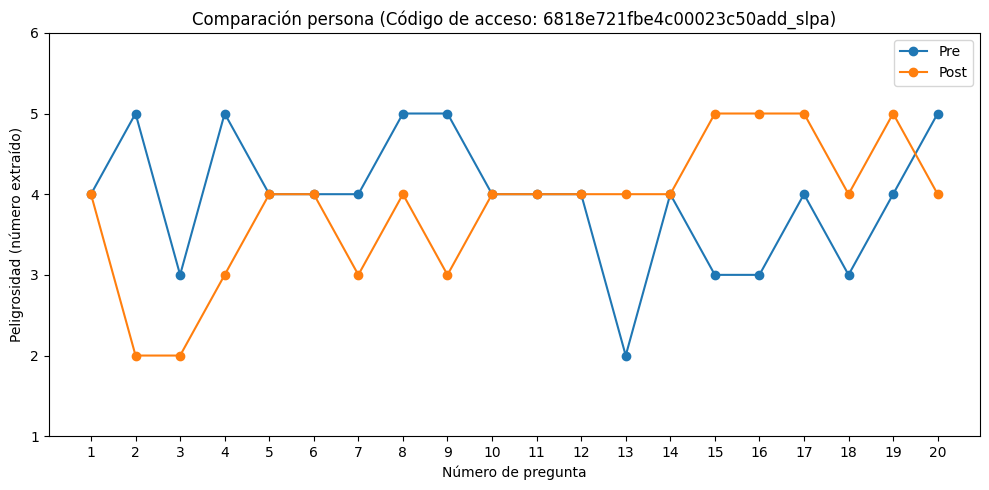

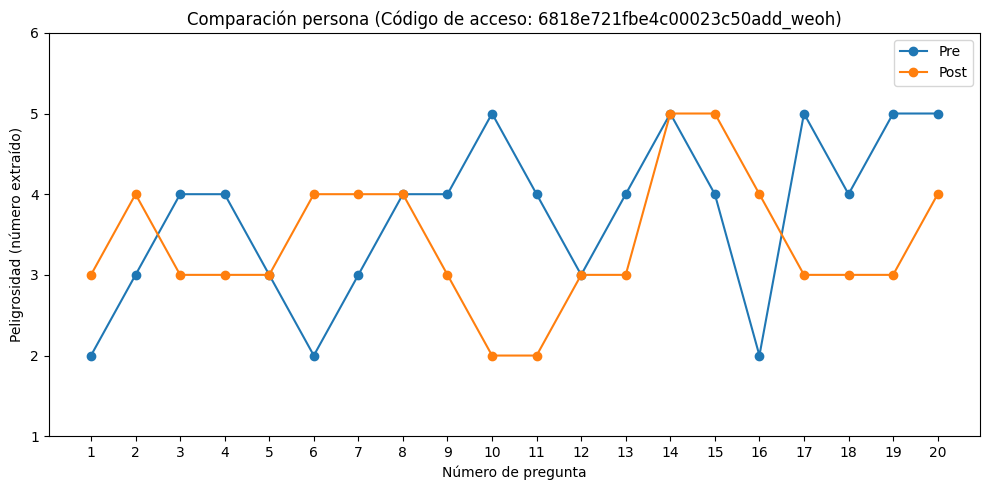

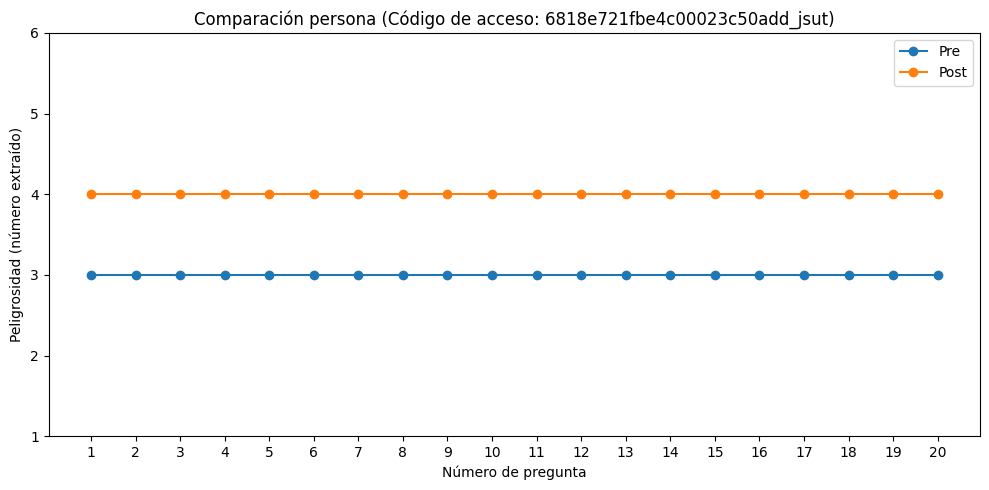

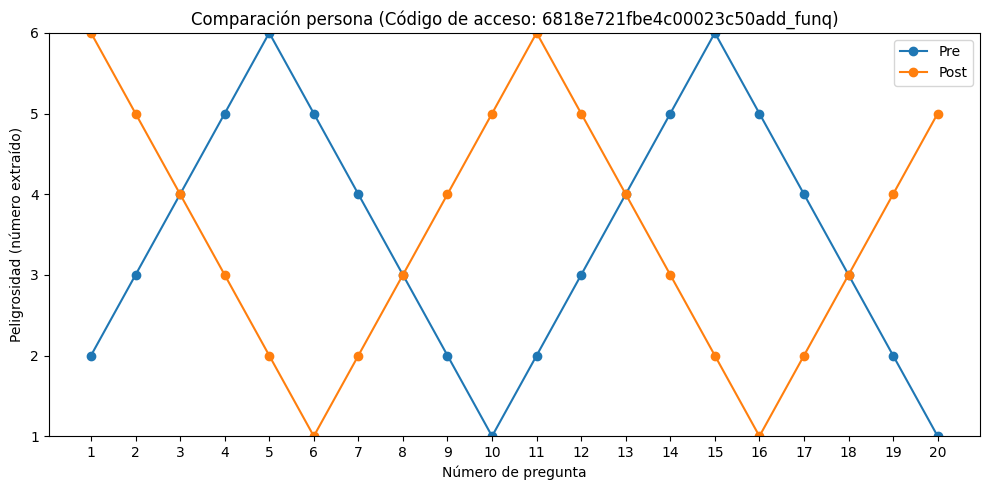

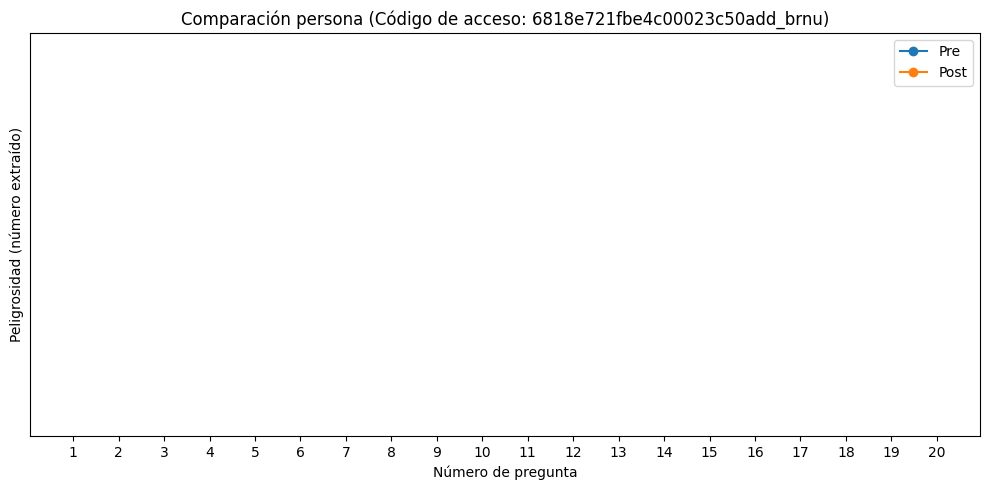

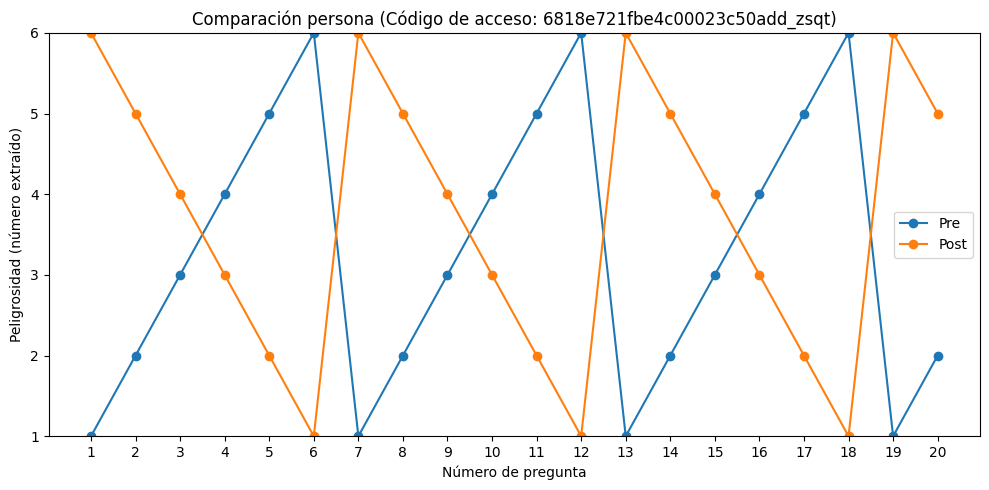

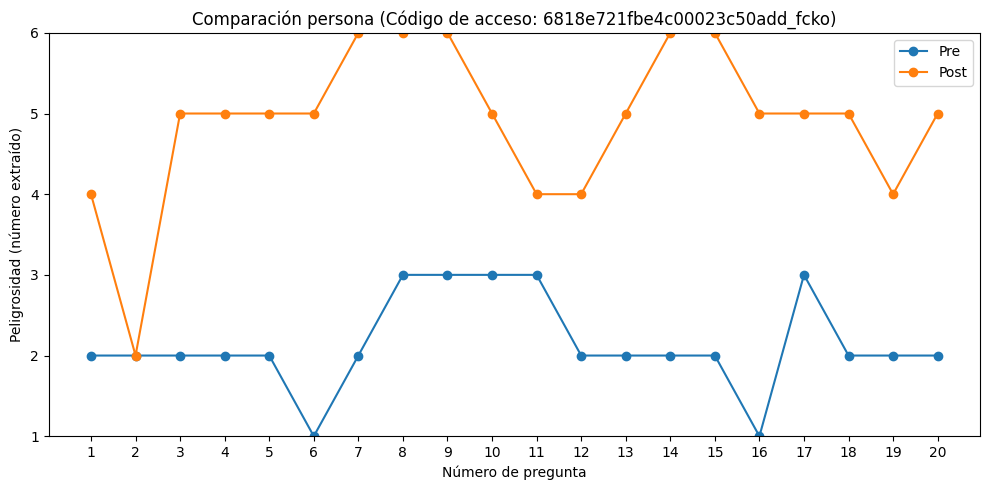

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def extraer_num(x):
    try:
        return int(str(x).split('-')[0].strip())
    except Exception:
        return x  # Si no es del formato esperado, lo deja igual

cols_modificar = pre.columns[4:]
print(cols_modificar)
datos1 = pre.copy()
datos2 = post.copy()

# Aplica la extracción solo a las columnas deseadas
datos1[cols_modificar] = datos1[cols_modificar].applymap(extraer_num)
datos2[cols_modificar] = datos2[cols_modificar].applymap(extraer_num)

for idx1, row1 in datos1.iterrows():
    codigo = row1["Código de acceso"]
    fila2 = datos2[datos2["Código de acceso"] == codigo]
    y1 = row1[cols_modificar].values
    x = range(1, len(cols_modificar) + 1)  # Eje X: número de pregunta
    plt.figure(figsize=(10, 5))
    plt.plot(x, y1, marker='o', label='Pre')
    if not fila2.empty:
        y2 = fila2.iloc[0][cols_modificar].values
        plt.plot(x, y2, marker='o', label='Post')
    plt.title(f'Comparación persona (Código de acceso: {codigo})')
    plt.xlabel('Número de pregunta')
    plt.ylabel('Peligrosidad')
    plt.ylim(1, 6)
    plt.legend()
    plt.xticks(x)
    plt.tight_layout()
    plt.show()


C:\Users\Nitropc\AppData\Local\Temp\ipykernel_12684\2534032344.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  datos1[cols_modificar] = datos1[cols_modificar].applymap(extraer_num)
C:\Users\Nitropc\AppData\Local\Temp\ipykernel_12684\2534032344.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  datos2[cols_modificar] = datos2[cols_modificar].applymap(extraer_num)


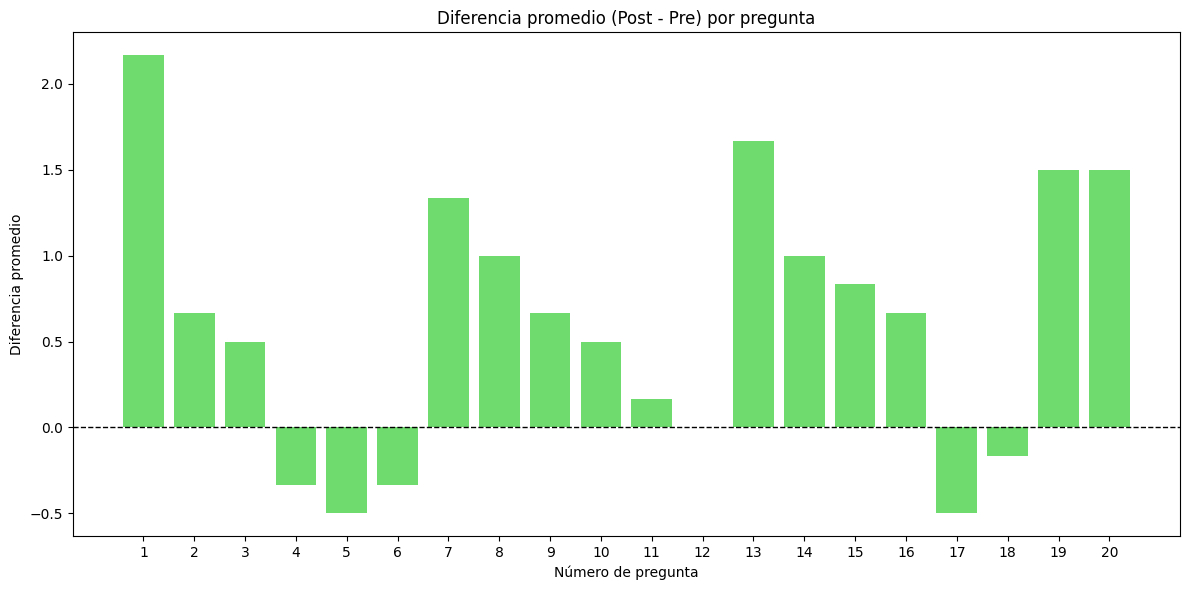

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

def extraer_num(x):
    try:
        return int(str(x).split('-')[0].strip())
    except Exception:
        return -1

cols_modificar = pre.columns[4:]
datos1 = pre.copy()
datos2 = post.copy()

datos1[cols_modificar] = datos1[cols_modificar].applymap(extraer_num)
datos2[cols_modificar] = datos2[cols_modificar].applymap(extraer_num)

diferencias = []

for idx1, row1 in datos1.iterrows():
    codigo = row1["Código de acceso"]
    fila2 = datos2[datos2["Código de acceso"] == codigo]
    y1 = row1[cols_modificar].values
    if not fila2.empty:
        y2 = fila2.iloc[0][cols_modificar].values
        if not (-1 in y1 or -1 in y2):
            diff = y2 - y1
            diferencias.append(diff)

# Convierte la lista en DataFrame para graficar fácilmente
diferencias_df = pd.DataFrame(diferencias, columns=cols_modificar)

x = np.arange(1, len(cols_modificar) + 1)
promedio = diferencias_df.mean()

plt.figure(figsize=(12, 6))
plt.bar(x, promedio, color='limegreen', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Diferencia promedio (Post - Pre) por pregunta')
plt.xlabel('Número de pregunta')
plt.ylabel('Diferencia promedio')
plt.xticks(x)
plt.tight_layout()
plt.show()

